# Fastqc Analysis: Slidingwindow4_20

## Author: Håkon Kaspersen
## Last updated: 16.08.2018

### This Notebook is used for visualizing fastqc-reports from multiple read sets.

### Load libraries

In [1]:
install.packages("pacman", repos = "http://cran.us.r-project.org")
pacman::p_load(fastqcr,dplyr,ggplot2,tidyr,viridis,ggsci,scales,svglite) 

package 'pacman' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\VI1511\AppData\Local\Temp\RtmpMvWvRT\downloaded_packages


### Specify input directory
##### Please specify the location of your fastqc.zip files.
##### Note: Specify the location of the folder holding the files. If the fastqc.zip files are located in multiple folders (for instance for grouping purposes), please specify the path to the directory holding all the folders. Also note that R use "/" and not "\" to specify folders, if copy-pasted from windows, please change to "/".

In [2]:
input_dir <- "D:/R_Data/fastqc/fastqc_trim_testing/Slidingwindow4_20/"

### Load functions
##### This activates all the functions used in this notebook.

In [3]:
# Function that lists all the file names in the input folder
file_names <- function(filepath, folder) {
  files <- list.files(path = paste0(filepath, "/", folder), pattern = "_fastqc.zip")
  return(files)
}

# Function that searches recursively for all filenames with fastqc.zip
file_names_recursive <- function(filepath) {
  files <- list.files(path = filepath, pattern = "_fastqc.zip", recursive = TRUE)
  return(files)
}

# Lists folders in the input folder
folder_names <- function(filepath) {
  folders <- list.files(path = filepath)
  return(folders)
}

# Identifies the names of the files and groups them accoring to their respective folders
get_grouping_variable <- function(path, folder) {
  files <- file_names(path, folder)
  df <- data.frame(files = files, group = folder, stringsAsFactors = FALSE)
  df$files <- gsub("(.*?)_fastqc.zip", "\\1", df$files)
  colnames(df) <- c("ref","group")
  return(df)
}

# Creates a data frame with grouping information of the reports
create_group_df <- function(path) {
  folders <- folder_names(path)
  if (length(folders) > 1) {
    df <- lapply(folders, function(folder) get_grouping_variable(path, folder))
    df <- bind_rows(df)
  } else {
    df <- get_grouping_variable(path, folders)
  }
  return(df)
}

# Function that filter out duplicated counts
filter_counts <- function(df) {
  df <- df %>%
    mutate(dupl = duplicated(Count)) %>%
    filter(dupl == FALSE)
  return(df)
}

# Function that prepares the sequence length data for plotting
prepare_seq_len_data <- function(list) {
  x <- split(list$sequence_length_distribution, list$sequence_length_distribution$group)
  x <- lapply(x, filter_counts)
  x <- bind_rows(x)
  return(x)
}

# Function that imports and wrangles fastqc data
get_fastqc_data <- function(filepath) {
  folders <- folder_names(filepath)
  
  get_files <- file_names_recursive(filepath)
  
  data_list <- lapply(get_files,
                      FUN = function(file) {
                        qc_read(paste0(filepath, "/", file),
                                modules = "all",
                                verbose = FALSE)
                      })
  names(data_list) <- gsub("(.*?)/(.*?)_fastqc.zip", "\\2", get_files)
  data_list <- purrr::transpose(data_list)
  
  data_list$sequence_length_distribution <- NULL
  data_list$kmer_content <- NULL
  
  list_names <- names(data_list)
  list_numbers <- 1:length(list_names)
  for (i in list_numbers) {
    assign(list_names[i], bind_rows(data_list[[i]], .id = "ref"))
  }
  df_list <- list(summary,
                  basic_statistics,
                  per_base_sequence_quality,
                  per_tile_sequence_quality,
                  per_sequence_quality_scores,
                  per_base_sequence_content,
                  per_sequence_gc_content,
                  per_base_n_content,
                  sequence_duplication_levels,
                  overrepresented_sequences,
                  adapter_content,
                  total_deduplicated_percentage)
  names(df_list) <- list_names
  df_list$basic_statistics <- df_list$basic_statistics %>%
    spread(Measure,Value) %>%
    left_join(group_df, by = "ref")
  return(df_list)
}

### Create grouping data frame
##### This function creates a data frame with the grouping information of the files, based on the folder names that hold them. Each file is specified a group name based on the folder they are in. This information is used to specify each group of files in the plots below.
##### Note: No changes should be made from here on!

In [4]:
group_df <- create_group_df(input_dir)

### Import data
##### This function imports the data from the location specified in the "input_dir" above.

In [5]:
df_list <- get_fastqc_data(input_dir)

### Adapter content
##### This plot presents the adapter content for all sequences in each group. Each adapter type is specified by color. The X-axis represents the read positions, where the left side represents the start of the read and the right side the end.

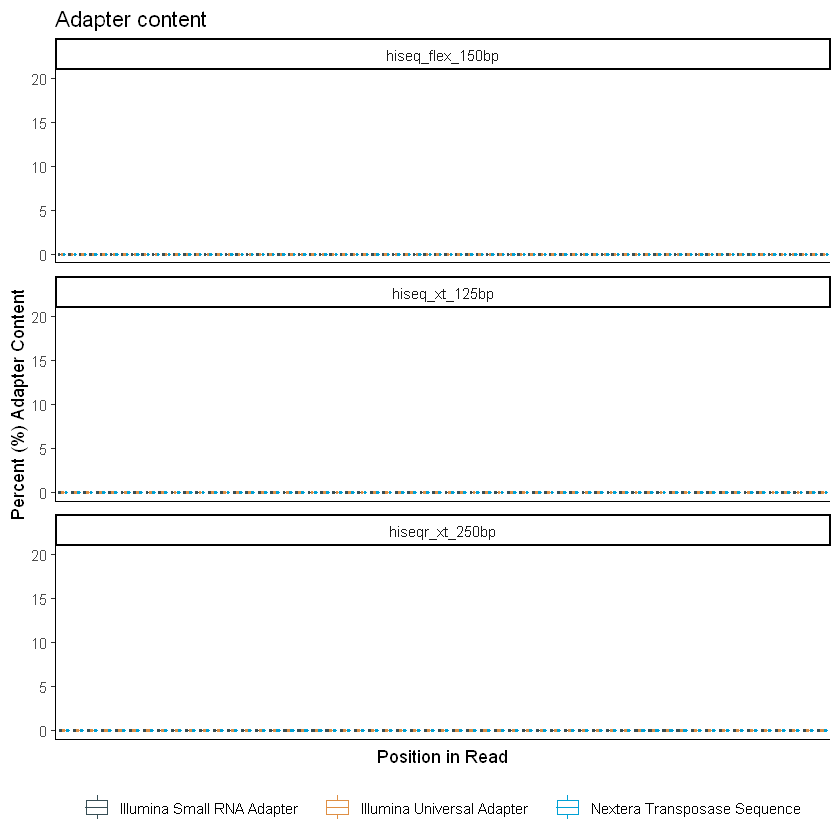

In [6]:
df_list$adapter_content %>%
    # import information from another data frame from same list,
    # to get grouping information etc.
    left_join(., df_list$basic_statistics[, c("ref", "Sequence length", "group")], by = "ref") %>%
    rename(seqlen = "Sequence length") %>%
    # get data ready for boxplot by gathering the columns into two columns
    gather(key,
           value, -c(ref,
                     Position,
                     group,
                     seqlen)) %>%
    # plotting
    ggplot(aes(factor(
      Position,
      levels = unique(Position),
      ordered = TRUE
    ), value, color = key)) +
    # specifies the ends of the boxplot as errorbars
    stat_boxplot(geom = "errorbar", width = 0.4) +
    geom_boxplot(outlier.size = 0.5) +
    labs(
      x = "Position in Read",
      y = "Percent (%) Adapter Content",
      color = NULL,
      title = "Adapter content"
    ) +
    scale_colour_jama() +
    scale_y_continuous(limits = c(0, 20)) +
    theme_classic() +
    theme(
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
      legend.position = "bottom"
    ) +
    # creates separate windows for each group
    facet_wrap(~ group, scales = "free", dir = "v")

### Per base sequence content
##### This plot presents the per base sequence content for all reads in each group. Each base is represented by color. 

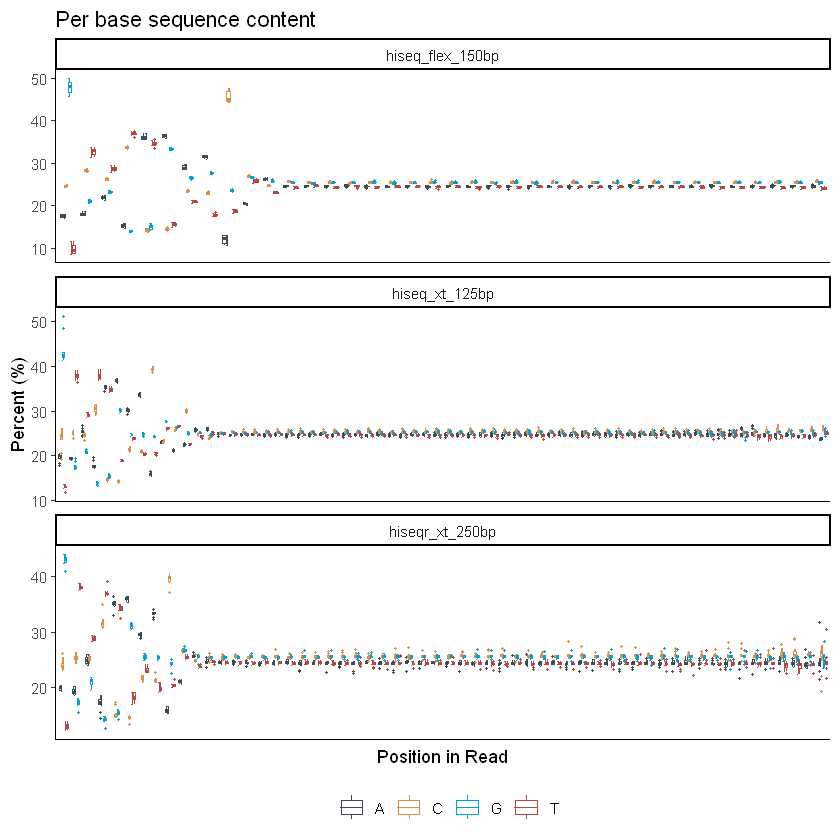

In [7]:
df_list$per_base_sequence_content %>%
    # import information from another data frame from same list,
    # to get grouping information etc.
    left_join(., df_list$basic_statistics[, c("ref", "Sequence length", "group")], by = "ref") %>%
    rename(seqlen = "Sequence length") %>%
    gather(key, value, -c(ref, Base, group, seqlen)) %>%
    ggplot(aes(factor(
      Base, levels = unique(Base), ordered = TRUE
    ), value, color = key)) +
    # specifies the ends of the boxplot as errorbars
    stat_boxplot(geom = "errorbar", width = 0.4) +
    geom_boxplot(outlier.size = 0.5) +
    labs(
      x = "Position in Read",
      y = "Percent (%)",
      color = NULL,
      title = "Per base sequence content"
    ) +
    theme_classic() +
    scale_color_jama() +
    theme(
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
      legend.position = "bottom"
    ) +
    # creates separate windows for each group
    facet_wrap( ~ group, scales = "free", dir = "v")

### Sequence duplication levels
##### This plot presents the duplication levels for all reads in each group. The X-axis contain "bins" of different duplication levels, and the number is a representation of how many of the same read is present. For example, the bin "3" represents the reads that have triplicates in the file. 

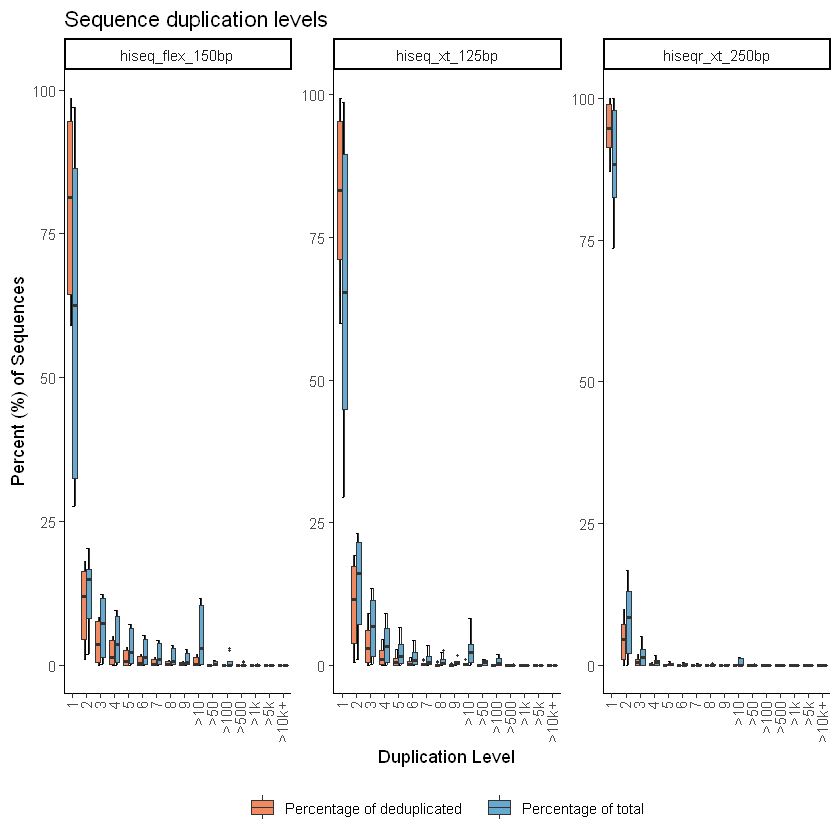

In [8]:
df_list$sequence_duplication_levels %>%
    # import information from another data frame from same list,
    # to get grouping information etc.
    left_join(., df_list$basic_statistics[, c("ref", "Sequence length", "group")], by = "ref") %>%
    rename(seqlen = "Sequence length") %>%
    gather(key, value, -c(ref, `Duplication Level`, group, seqlen)) %>%
    ggplot(aes(
      factor(
        `Duplication Level`,
        levels = unique(`Duplication Level`),
        ordered = TRUE
      ),
      value,
      fill = key
    )) +
    # specifies the ends of the boxplot as errorbars
    stat_boxplot(geom = "errorbar", width = 0.4) +
    geom_boxplot(outlier.size = 0.5) +
    scale_fill_manual(values = c("#ef8a62",
                                 "#67a9cf")) +
    theme_classic() +
    labs(x = "Duplication Level",
         y = "Percent (%) of Sequences",
         fill = NULL,
         title = "Sequence duplication levels") +
    theme(legend.position = "bottom",
          axis.text.x = element_text(
            angle = 90,
            hjust = 1,
            vjust = 0.4
          )) +
    # creates separate windows for each group
    facet_wrap( ~ group, scales = "free")

### Sequence quality scores
##### This plot presents the sequence quality scores for all reads in each group. The X-axis represent the phred-score for each read, and the y-axis represent the amount of reads per phred-score. Higher score is better.

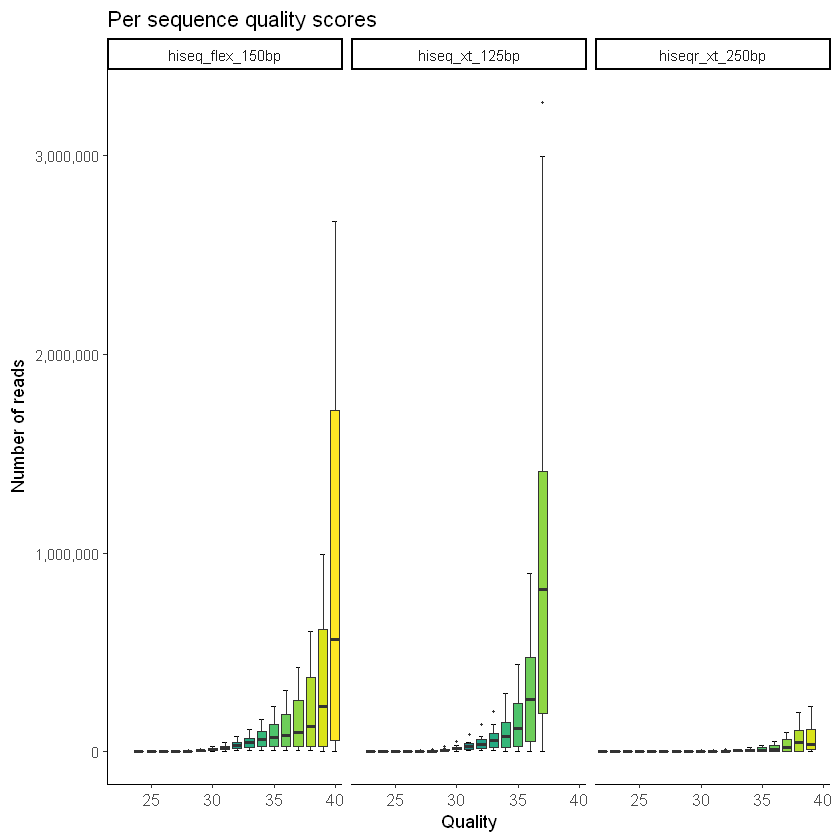

In [9]:
df_list$per_sequence_quality_scores %>%
    # import information from another data frame from same list,
    # to get grouping information etc.
    left_join(., df_list$basic_statistics[, c("ref", "Sequence length", "group")], by = "ref") %>%
    rename(seqlen = "Sequence length") %>%
    ggplot(aes(factor(Quality), Count, fill = factor(Quality))) +
    # specifies the ends of the boxplot as errorbars
    stat_boxplot(geom = "errorbar", width = 0.4) +
    geom_boxplot(outlier.size = 0.5) +
    scale_y_continuous(labels = comma) +
    scale_x_discrete(breaks = c(0, 5, 10, 15, 20, 25, 30, 35, 40)) +
    scale_fill_viridis(discrete = TRUE) +
    labs(x = "Quality",
         y = "Number of reads",
         title = "Per sequence quality scores") +
    guides(fill = FALSE) +
    theme_classic() +
    theme(axis.text.x = element_text(size = 10)) +
    # creates separate windows for each group
    facet_wrap( ~ group)

### Per sequence GC content
##### This plot presents the % GC-content for all reads in each group.

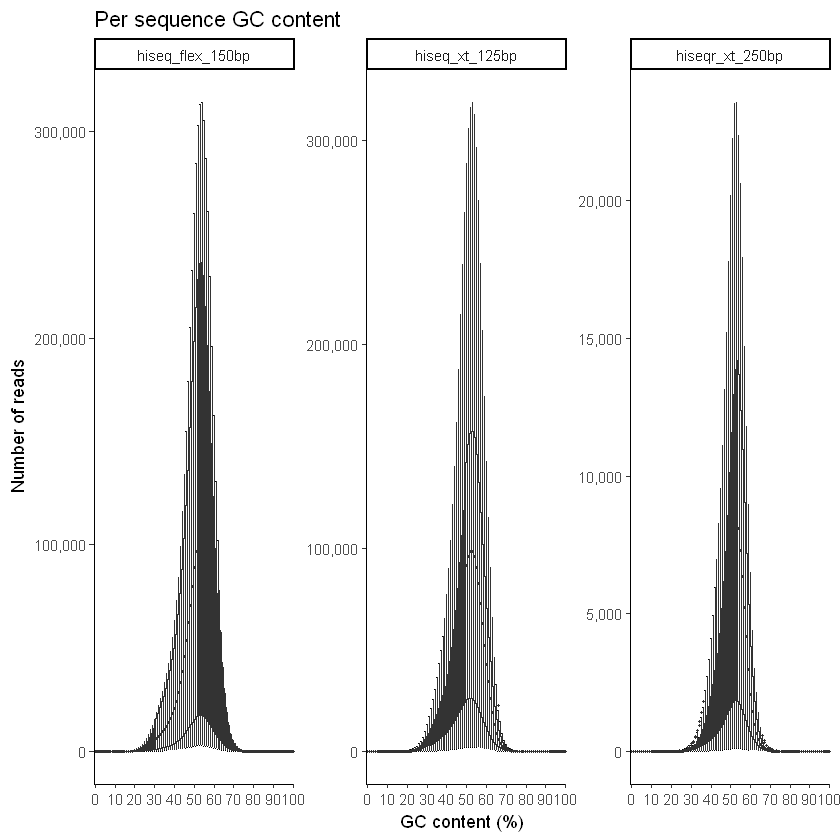

In [10]:
df_list$per_sequence_gc_content %>%
    # import information from another data frame from same list,
    # to get grouping information etc.
    left_join(., df_list$basic_statistics[, c("ref", "Sequence length", "group")], by = "ref") %>%
    rename(seqlen = "Sequence length") %>%
    ggplot(aes(factor(`GC Content`), Count)) +
    # specifies the ends of the boxplot as errorbars
    stat_boxplot(geom = "errorbar", width = 0.4) +
    geom_boxplot(outlier.size = 0.5) +
    labs(x = "GC content (%)",
         y = "Number of reads",
         title = "Per sequence GC content") +
    scale_y_continuous(labels = comma) +
    scale_x_discrete(breaks = as.character(seq(
      from = 0, to = 100, by = 10
    ))) +
    theme_classic() +
    # creates separate windows for each group
    facet_wrap( ~ group, scales = "free")

### Per base N content
##### This plot presents the per base N content for all reads in each group. N's are added to the read instead of a base if the sequencer is unable to do the base call with sufficient confidence. As before , the X-axis represents the position in the read, where left is the start of the read and right is the end.

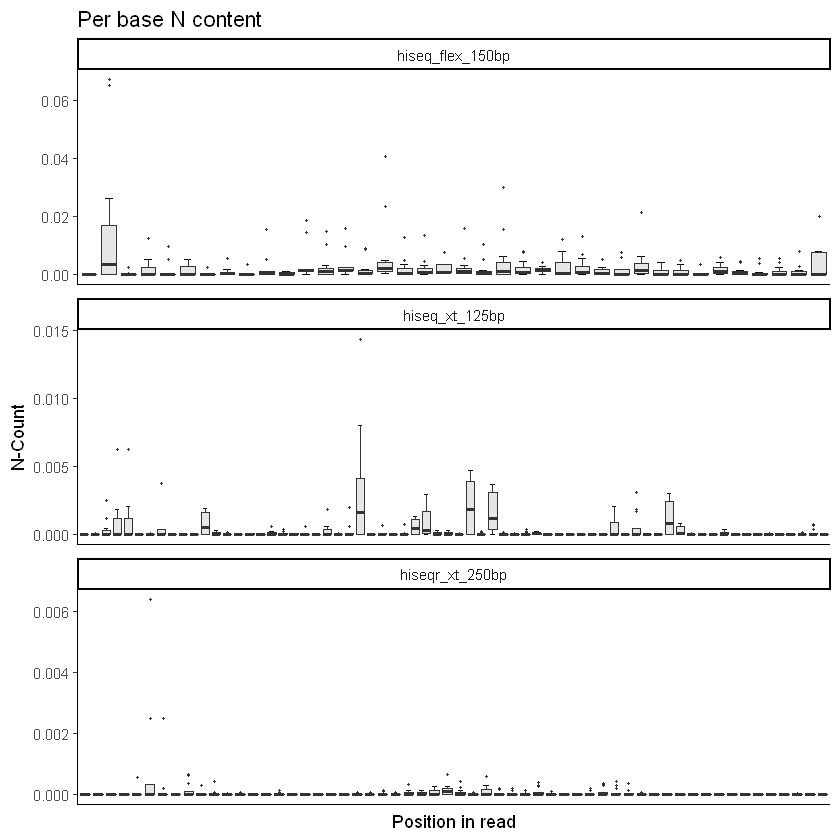

In [11]:
df_list$per_base_n_content %>%
    # import information from another data frame from same list,
    # to get grouping information etc.
    left_join(., df_list$basic_statistics[, c("ref", "Sequence length", "group")], by = "ref") %>%
    rename(seqlen = "Sequence length") %>%
    ggplot(aes(factor(
      Base, levels = unique(Base), ordered = TRUE
    ), `N-Count`)) +
    # specifies the ends of the boxplot as errorbars
    stat_boxplot(geom = "errorbar", width = 0.4) +
    geom_boxplot(fill = "#e6e6e6",
                 outlier.size = 0.5) +
    labs(x = "Position in read",
         title = "Per base N content") +
    guides(fill = FALSE) +
    theme_classic() +
    theme(axis.text.x = element_blank(),
          axis.ticks.x = element_blank()) +
    # creates separate windows for each group
    facet_wrap( ~ group, scales = "free", dir = "v")

### Total deduplicated percentage
##### This plot presents the total deduplicated percentage for all reads in each group.

Warning message:
"package 'bindrcpp' was built under R version 3.4.4"

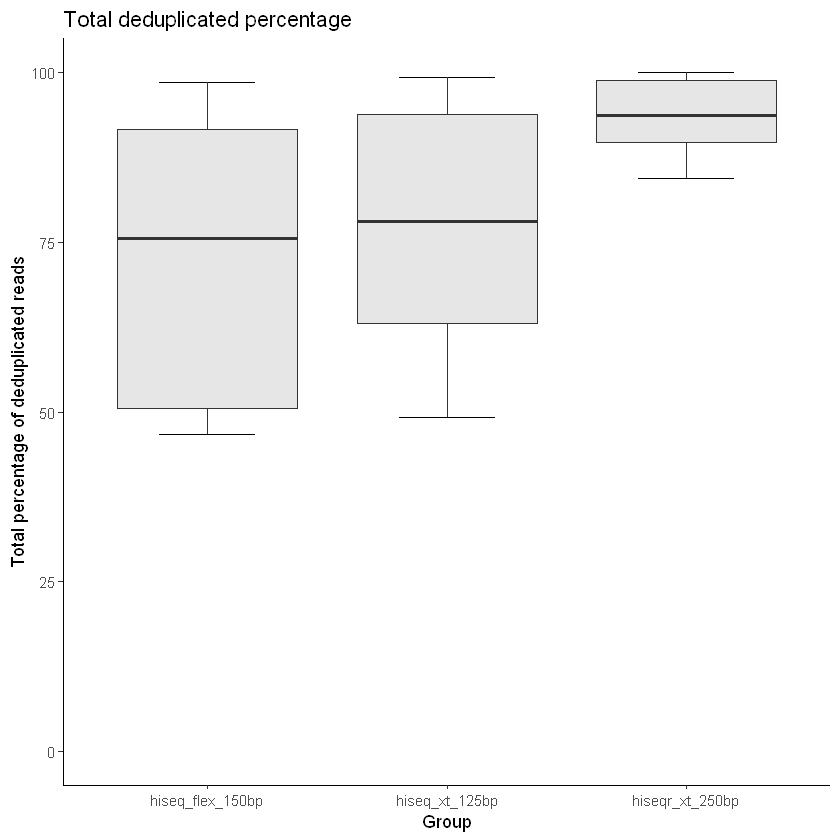

In [12]:
df_list$total_deduplicated_percentage %>%
    gather(key = "ref", value = `1`) %>%
    # import information from another data frame from same list,
    # to get grouping information etc.
    left_join(., df_list$basic_statistics[, c("ref", "Sequence length", "group")], by = "ref") %>%
    rename(seqlen = "Sequence length",
           perc = `1`) %>%
    mutate(perc = as.numeric(perc)) %>%
    ggplot(aes(factor(group), perc)) +
    # specifies the ends of the boxplot as errorbars
    stat_boxplot(geom = "errorbar", width = 0.4) +
    geom_boxplot(fill = "#e6e6e6",
                 outlier.size = 0.5) + 
    scale_y_continuous(limits = c(0, 100)) +
    labs(x = "Group",
         y = "Total percentage of deduplicated reads",
         title = "Total deduplicated percentage") +
    theme_classic()

### Per base mean sequence quality
##### This plot presents the per base mean sequence quality for all reads in each group. The green line depicts the "good quality" limit of the phred-score 28. As before, the X-axis represents the position in each read.

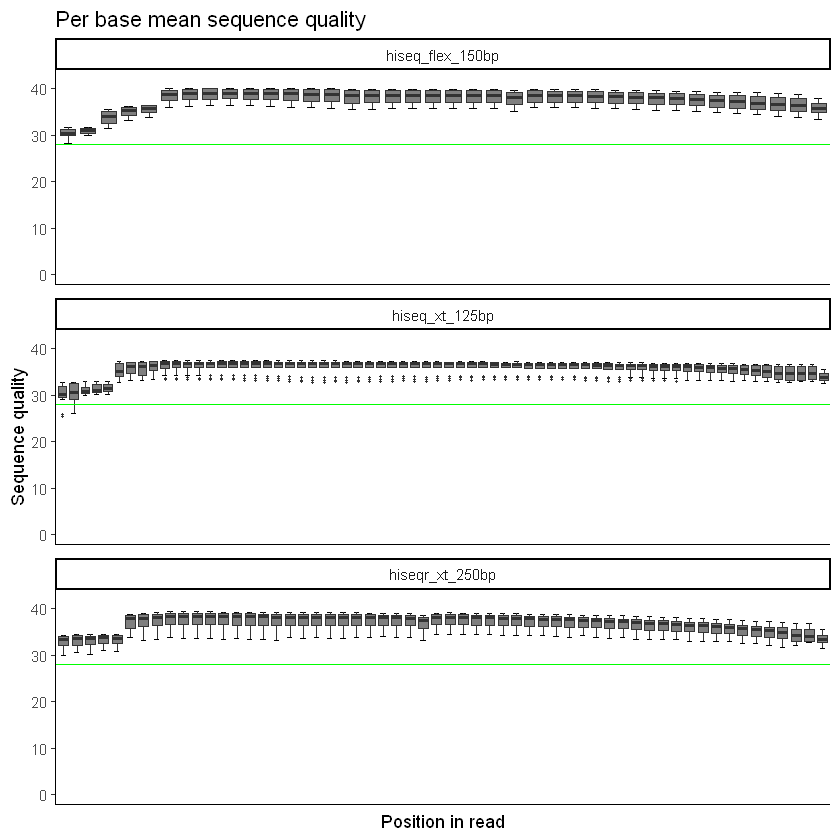

In [13]:
df_list$per_base_sequence_quality %>%
    # import information from another data frame from same list,
    # to get grouping information etc.
    left_join(., df_list$basic_statistics[, c("ref", "Sequence length", "group")], by = "ref") %>%
    rename(seqlen = "Sequence length") %>%
    mutate(Base = factor(Base,
                         levels = unique(Base),
                         ordered = TRUE)) %>%
    group_by(group) %>%
    mutate(xmax = length(unique(Base)) + 1) %>%
    ungroup() %>%
    ggplot(aes(Base,
               Mean)) +
    # specifies the ends of the boxplot as errorbars
    stat_boxplot(geom = "errorbar", width = 0.4) +
    geom_boxplot(outlier.size = 0.4,
                 fill = "#7f7f7f") +
    geom_hline(aes(yintercept = 28),
               color = "green") +
    labs(x = "Position in read",
         y = "Sequence quality",
         title = "Per base mean sequence quality") +
    scale_y_continuous(limits = c(0, 42)) +
    theme_classic() +
    theme(axis.text.x = element_blank(),
          axis.ticks.x = element_blank()) +
    # creates separate windows for each group
    facet_wrap(~ group, scales = "free", dir = "v")